# Genrative Adversarial Network (Pytorch Implementation)

In [71]:
import torch
import torch_directml
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Generator

In [72]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=2,
                               padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 5, stride=2,
                               padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discriminator

In [73]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1)
        )

    def forward(self, x):
        return self.main(x)

In [74]:
NOISE_DIM = 100

generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [75]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# generator = generator.to(device)
# discriminator = discriminator.to(device)

In [76]:
# For WSL
device = torch_directml.device()
print(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

privateuseone:0


In [ ]:
criterion = nn.BCEWithLogitsLoss()

generator_optimizer = optim.Adam(
    generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(
    discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

NUM_EPOCHS = 30
BATCH_SIZE = 256

In [78]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [79]:
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)

        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

Epoch [1/30], Step [1/235], Discriminator Loss: 1.7178, Generator Loss: 0.7920
Epoch [1/30], Step [101/235], Discriminator Loss: 0.7241, Generator Loss: 1.6270
Epoch [1/30], Step [201/235], Discriminator Loss: 0.1421, Generator Loss: 2.9455
Epoch [2/30], Step [1/235], Discriminator Loss: 0.0462, Generator Loss: 4.0946
Epoch [2/30], Step [101/235], Discriminator Loss: 0.0099, Generator Loss: 6.0616
Epoch [2/30], Step [201/235], Discriminator Loss: 0.0060, Generator Loss: 6.1713
Epoch [3/30], Step [1/235], Discriminator Loss: 0.0046, Generator Loss: 6.5075
Epoch [3/30], Step [101/235], Discriminator Loss: 0.0040, Generator Loss: 6.6889
Epoch [3/30], Step [201/235], Discriminator Loss: 0.0023, Generator Loss: 7.3625
Epoch [4/30], Step [1/235], Discriminator Loss: 0.0023, Generator Loss: 7.5340
Epoch [4/30], Step [101/235], Discriminator Loss: 0.0016, Generator Loss: 7.4583
Epoch [4/30], Step [201/235], Discriminator Loss: 0.0016, Generator Loss: 7.9711
Epoch [5/30], Step [1/235], Discrimi

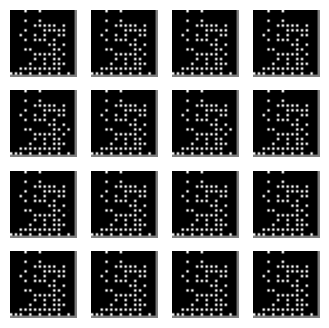

In [80]:
def generate_and_save_images(model, epoch, noise):
    model.eval()
    with torch.no_grad():
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)

        fig = plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()


test_noise = torch.randn(16, NOISE_DIM, device=device)
generate_and_save_images(generator, NUM_EPOCHS, test_noise)